## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Transform the Data

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## Load the Data

In [4]:
# Load CIFAR 10 dataset with training and testing Components
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 45779886.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualize a few images

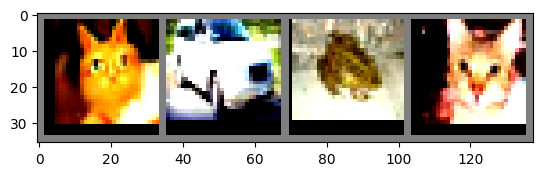

In [5]:
import matplotlib.pyplot as plt
import numpy as np


batch_size = 4

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

## Define ResNet Architecture

We have modified the architecture to reduce blocks in layers. The following modifications were made to ResNet 18 architecture found at https://github.com/kuangliu/pytorch-cifar. 

- Removing a block of 512 filters and extending each layer from 2 blocks per layer to 3 blocks per layer 
- Dropout of 0.4 added
- SGD optimizer


In [6]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [3,3,3])

In [7]:
net = ResNet18()

In [8]:
## Move model to CUDA
net = net.to(device)

## Model Summary and Parameters
eters
We are checking total number of trainable params and visualizing the model summary

In [9]:
summary(net, input_size = (3,32,32), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [10]:
total_trainable_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [11]:
print("Total Trainable Parameters: %d"%total_trainable_parameters)

Total Trainable Parameters: 4327754


Which is under 5 million :)

## Define Train and Test functions 

In [12]:
# Training
def train(epoch):
    
    ## Setting the model in training mode
    net.train()
    
    ## Initialize Epoch loss and accuracy 
    train_loss = 0
    train_acc = 0 
    
    ## Number of correct examples
    correct = 0
    total = 0


    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ## Movie inputs and targets to cuda
        inputs, targets = inputs.to(device), targets.to(device)

        ## Set gradients to zero after every batch
        optimizer.zero_grad()

        ## Get predictions
        outputs = net(inputs)

        ## Compute Loss
        loss = criterion(outputs, targets)

        ## Do backprop
        loss.backward()

        ## Update weights 
        optimizer.step()

        ## Add loss
        train_loss += loss.item()
        
        ## Computer Number of correct examples
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    
    
    
    train_acc += 100.*correct/total


   
    
    return train_loss / len(trainloader) , train_acc

In [13]:
def test(epoch):
    ## Setting models to evaluation mode
    net.eval()
    
    ## Initialize epoch loss and accuracy
    test_loss = 0
    test_acc = 0 

    ## Number of correct examples
    correct = 0
    total = 0


    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            ## Move inputs and targets to cuda

            inputs, targets = inputs.to(device), targets.to(device)

            ## Get predictions

            outputs = net(inputs)

            ## Compute Loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            ## Computer Accuracy 
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    test_acc = 100.*correct/total
    
    return test_loss / len(testloader) , test_acc

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Defining Loss function, optimizer and LR Scheduler

In [15]:
LEARNING_RATE = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE,
                       weight_decay=5e-4 , momentum = 0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = criterion.to(device)

## Train the model


In [16]:
EPOCHS = 130
best_testing_accuracy = 0 

## Define model history to store accuracy and losses

history = {}
history["accuracy"] = []
history["test_accuracy"] = []
history["loss"] = []
history["test_loss"] = []

In [17]:
## First train for 130 

for epoch in tqdm(range(EPOCHS)):
  
  start_time = time.time()

  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)

  scheduler.step()

  history["accuracy"].append(train_acc)
  history["test_accuracy"].append(test_acc)
  history["loss"].append(train_loss)
  history["test_loss"].append(test_loss)


  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if test_acc > best_testing_accuracy:
    best_testing_accuracy = test_acc
    torch.save(net.state_dict(), 'model.pt')

  
  print('Training Loss: %.3f | Training Acc: %.3f%% | Testing Loss: %.3f | Testing Acc:%.3f%%'
                  % (train_loss, train_acc, test_loss, test_acc))

  1%|          | 1/130 [00:49<1:45:49, 49.22s/it]

Training Loss: 1.943 | Training Acc: 28.890% | Testing Loss: 1.621 | Testing Acc:38.680%


  2%|▏         | 2/130 [01:39<1:45:46, 49.58s/it]

Training Loss: 1.443 | Training Acc: 46.818% | Testing Loss: 1.327 | Testing Acc:52.350%


  2%|▏         | 3/130 [02:29<1:45:36, 49.89s/it]

Training Loss: 1.173 | Training Acc: 57.692% | Testing Loss: 1.299 | Testing Acc:54.320%


  3%|▎         | 4/130 [03:19<1:45:17, 50.14s/it]

Training Loss: 1.006 | Training Acc: 64.378% | Testing Loss: 1.114 | Testing Acc:61.400%


  4%|▍         | 5/130 [04:10<1:44:37, 50.22s/it]

Training Loss: 0.884 | Training Acc: 69.072% | Testing Loss: 0.844 | Testing Acc:70.810%


  5%|▍         | 6/130 [05:00<1:43:59, 50.32s/it]

Training Loss: 0.774 | Training Acc: 73.290% | Testing Loss: 0.900 | Testing Acc:70.580%


  5%|▌         | 7/130 [05:51<1:43:10, 50.33s/it]

Training Loss: 0.678 | Training Acc: 76.864% | Testing Loss: 0.867 | Testing Acc:71.880%


  6%|▌         | 8/130 [06:41<1:42:20, 50.33s/it]

Training Loss: 0.624 | Training Acc: 78.912% | Testing Loss: 0.739 | Testing Acc:74.950%


  7%|▋         | 9/130 [07:31<1:41:40, 50.41s/it]

Training Loss: 0.582 | Training Acc: 80.452% | Testing Loss: 0.880 | Testing Acc:72.830%


  8%|▊         | 10/130 [08:22<1:40:43, 50.37s/it]

Training Loss: 0.557 | Training Acc: 81.122% | Testing Loss: 0.884 | Testing Acc:71.720%


  8%|▊         | 11/130 [09:12<1:40:07, 50.48s/it]

Training Loss: 0.532 | Training Acc: 82.036% | Testing Loss: 0.663 | Testing Acc:78.950%


  9%|▉         | 12/130 [10:04<1:39:37, 50.66s/it]

Training Loss: 0.511 | Training Acc: 82.854% | Testing Loss: 0.649 | Testing Acc:78.220%


 10%|█         | 13/130 [10:54<1:38:54, 50.73s/it]

Training Loss: 0.490 | Training Acc: 83.502% | Testing Loss: 0.866 | Testing Acc:72.230%


 11%|█         | 14/130 [11:46<1:38:22, 50.88s/it]

Training Loss: 0.480 | Training Acc: 83.874% | Testing Loss: 0.639 | Testing Acc:79.100%


 12%|█▏        | 15/130 [12:36<1:37:23, 50.81s/it]

Training Loss: 0.465 | Training Acc: 84.336% | Testing Loss: 0.604 | Testing Acc:80.430%


 12%|█▏        | 16/130 [13:27<1:36:14, 50.66s/it]

Training Loss: 0.455 | Training Acc: 84.672% | Testing Loss: 0.492 | Testing Acc:83.230%


 13%|█▎        | 17/130 [14:17<1:35:24, 50.66s/it]

Training Loss: 0.445 | Training Acc: 85.044% | Testing Loss: 0.556 | Testing Acc:80.960%


 14%|█▍        | 18/130 [15:08<1:34:30, 50.63s/it]

Training Loss: 0.435 | Training Acc: 85.358% | Testing Loss: 0.507 | Testing Acc:82.560%


 15%|█▍        | 19/130 [15:58<1:33:28, 50.52s/it]

Training Loss: 0.426 | Training Acc: 85.838% | Testing Loss: 0.747 | Testing Acc:76.740%


 15%|█▌        | 20/130 [16:49<1:32:47, 50.61s/it]

Training Loss: 0.419 | Training Acc: 86.034% | Testing Loss: 0.885 | Testing Acc:74.690%


 16%|█▌        | 21/130 [17:40<1:32:19, 50.82s/it]

Training Loss: 0.410 | Training Acc: 86.292% | Testing Loss: 0.632 | Testing Acc:80.070%


 17%|█▋        | 22/130 [18:31<1:31:22, 50.77s/it]

Training Loss: 0.405 | Training Acc: 86.216% | Testing Loss: 0.513 | Testing Acc:83.360%


 18%|█▊        | 23/130 [19:22<1:30:27, 50.72s/it]

Training Loss: 0.394 | Training Acc: 86.704% | Testing Loss: 0.612 | Testing Acc:80.510%


 18%|█▊        | 24/130 [20:12<1:29:34, 50.70s/it]

Training Loss: 0.396 | Training Acc: 86.618% | Testing Loss: 0.629 | Testing Acc:79.270%


 19%|█▉        | 25/130 [21:03<1:28:52, 50.79s/it]

Training Loss: 0.385 | Training Acc: 87.032% | Testing Loss: 0.780 | Testing Acc:76.700%


 20%|██        | 26/130 [21:54<1:28:11, 50.88s/it]

Training Loss: 0.382 | Training Acc: 87.174% | Testing Loss: 0.560 | Testing Acc:81.510%


 21%|██        | 27/130 [22:45<1:27:26, 50.93s/it]

Training Loss: 0.380 | Training Acc: 87.150% | Testing Loss: 0.481 | Testing Acc:83.870%


 22%|██▏       | 28/130 [23:36<1:26:41, 51.00s/it]

Training Loss: 0.373 | Training Acc: 87.486% | Testing Loss: 0.660 | Testing Acc:79.910%


 22%|██▏       | 29/130 [24:27<1:25:42, 50.92s/it]

Training Loss: 0.365 | Training Acc: 87.694% | Testing Loss: 0.572 | Testing Acc:82.190%


 23%|██▎       | 30/130 [25:18<1:24:42, 50.82s/it]

Training Loss: 0.368 | Training Acc: 87.640% | Testing Loss: 0.496 | Testing Acc:84.310%


 24%|██▍       | 31/130 [26:08<1:23:41, 50.72s/it]

Training Loss: 0.362 | Training Acc: 87.936% | Testing Loss: 0.489 | Testing Acc:83.950%


 25%|██▍       | 32/130 [26:59<1:22:44, 50.66s/it]

Training Loss: 0.355 | Training Acc: 88.120% | Testing Loss: 0.442 | Testing Acc:85.200%


 25%|██▌       | 33/130 [27:49<1:21:42, 50.54s/it]

Training Loss: 0.353 | Training Acc: 88.124% | Testing Loss: 0.646 | Testing Acc:79.690%


 26%|██▌       | 34/130 [28:39<1:20:48, 50.51s/it]

Training Loss: 0.346 | Training Acc: 88.226% | Testing Loss: 0.489 | Testing Acc:83.510%


 27%|██▋       | 35/130 [29:30<1:20:03, 50.57s/it]

Training Loss: 0.351 | Training Acc: 88.072% | Testing Loss: 0.493 | Testing Acc:83.730%


 28%|██▊       | 36/130 [30:21<1:19:16, 50.60s/it]

Training Loss: 0.338 | Training Acc: 88.674% | Testing Loss: 0.494 | Testing Acc:84.650%


 28%|██▊       | 37/130 [31:12<1:18:41, 50.77s/it]

Training Loss: 0.339 | Training Acc: 88.532% | Testing Loss: 0.421 | Testing Acc:85.920%


 29%|██▉       | 38/130 [32:03<1:18:06, 50.94s/it]

Training Loss: 0.336 | Training Acc: 88.690% | Testing Loss: 0.491 | Testing Acc:84.460%


 30%|███       | 39/130 [32:54<1:17:16, 50.95s/it]

Training Loss: 0.337 | Training Acc: 88.720% | Testing Loss: 0.442 | Testing Acc:84.860%


 31%|███       | 40/130 [33:46<1:16:31, 51.02s/it]

Training Loss: 0.324 | Training Acc: 89.032% | Testing Loss: 0.537 | Testing Acc:83.090%


 32%|███▏      | 41/130 [34:37<1:15:59, 51.23s/it]

Training Loss: 0.334 | Training Acc: 88.668% | Testing Loss: 0.563 | Testing Acc:82.030%


 32%|███▏      | 42/130 [35:28<1:14:59, 51.13s/it]

Training Loss: 0.329 | Training Acc: 88.818% | Testing Loss: 0.501 | Testing Acc:83.680%


 33%|███▎      | 43/130 [36:20<1:14:14, 51.20s/it]

Training Loss: 0.324 | Training Acc: 89.070% | Testing Loss: 0.430 | Testing Acc:86.310%


 34%|███▍      | 44/130 [37:11<1:13:30, 51.28s/it]

Training Loss: 0.320 | Training Acc: 89.394% | Testing Loss: 0.496 | Testing Acc:83.770%


 35%|███▍      | 45/130 [38:02<1:12:32, 51.21s/it]

Training Loss: 0.315 | Training Acc: 89.288% | Testing Loss: 0.388 | Testing Acc:87.140%


 35%|███▌      | 46/130 [38:53<1:11:39, 51.19s/it]

Training Loss: 0.320 | Training Acc: 89.276% | Testing Loss: 0.464 | Testing Acc:85.140%


 36%|███▌      | 47/130 [39:44<1:10:36, 51.05s/it]

Training Loss: 0.312 | Training Acc: 89.466% | Testing Loss: 0.519 | Testing Acc:84.140%


 37%|███▋      | 48/130 [40:34<1:09:30, 50.86s/it]

Training Loss: 0.317 | Training Acc: 89.410% | Testing Loss: 0.449 | Testing Acc:85.030%


 38%|███▊      | 49/130 [41:25<1:08:32, 50.77s/it]

Training Loss: 0.309 | Training Acc: 89.550% | Testing Loss: 0.555 | Testing Acc:83.190%


 38%|███▊      | 50/130 [42:16<1:07:40, 50.75s/it]

Training Loss: 0.310 | Training Acc: 89.578% | Testing Loss: 0.461 | Testing Acc:84.990%


 39%|███▉      | 51/130 [43:06<1:06:40, 50.64s/it]

Training Loss: 0.294 | Training Acc: 90.236% | Testing Loss: 0.387 | Testing Acc:87.530%


 40%|████      | 52/130 [43:56<1:05:45, 50.58s/it]

Training Loss: 0.307 | Training Acc: 89.614% | Testing Loss: 0.431 | Testing Acc:85.800%


 41%|████      | 53/130 [44:47<1:04:49, 50.52s/it]

Training Loss: 0.302 | Training Acc: 89.890% | Testing Loss: 0.479 | Testing Acc:85.200%


 42%|████▏     | 54/130 [45:37<1:03:55, 50.47s/it]

Training Loss: 0.290 | Training Acc: 90.250% | Testing Loss: 0.501 | Testing Acc:83.900%


 42%|████▏     | 55/130 [46:28<1:03:13, 50.58s/it]

Training Loss: 0.294 | Training Acc: 90.100% | Testing Loss: 0.539 | Testing Acc:83.010%


 43%|████▎     | 56/130 [47:19<1:02:30, 50.68s/it]

Training Loss: 0.292 | Training Acc: 90.122% | Testing Loss: 0.477 | Testing Acc:84.360%


 44%|████▍     | 57/130 [48:10<1:01:45, 50.75s/it]

Training Loss: 0.289 | Training Acc: 90.242% | Testing Loss: 0.435 | Testing Acc:85.950%


 45%|████▍     | 58/130 [49:01<1:01:03, 50.88s/it]

Training Loss: 0.293 | Training Acc: 90.020% | Testing Loss: 0.372 | Testing Acc:87.370%


 45%|████▌     | 59/130 [49:53<1:00:36, 51.22s/it]

Training Loss: 0.285 | Training Acc: 90.490% | Testing Loss: 0.455 | Testing Acc:85.100%


 46%|████▌     | 60/130 [50:44<59:38, 51.12s/it]  

Training Loss: 0.282 | Training Acc: 90.450% | Testing Loss: 0.442 | Testing Acc:85.520%


 47%|████▋     | 61/130 [51:35<58:48, 51.13s/it]

Training Loss: 0.286 | Training Acc: 90.320% | Testing Loss: 0.493 | Testing Acc:84.980%


 48%|████▊     | 62/130 [52:26<57:54, 51.10s/it]

Training Loss: 0.281 | Training Acc: 90.582% | Testing Loss: 0.959 | Testing Acc:74.190%


 48%|████▊     | 63/130 [53:17<56:52, 50.93s/it]

Training Loss: 0.271 | Training Acc: 90.848% | Testing Loss: 0.527 | Testing Acc:83.230%


 49%|████▉     | 64/130 [54:07<55:55, 50.84s/it]

Training Loss: 0.283 | Training Acc: 90.422% | Testing Loss: 0.408 | Testing Acc:87.020%


 50%|█████     | 65/130 [54:58<54:57, 50.73s/it]

Training Loss: 0.271 | Training Acc: 90.860% | Testing Loss: 0.456 | Testing Acc:85.140%


 51%|█████     | 66/130 [55:48<53:56, 50.57s/it]

Training Loss: 0.274 | Training Acc: 90.696% | Testing Loss: 0.401 | Testing Acc:86.600%


 52%|█████▏    | 67/130 [56:38<52:59, 50.47s/it]

Training Loss: 0.271 | Training Acc: 90.860% | Testing Loss: 0.380 | Testing Acc:87.340%


 52%|█████▏    | 68/130 [57:28<52:05, 50.42s/it]

Training Loss: 0.262 | Training Acc: 91.340% | Testing Loss: 0.475 | Testing Acc:84.570%


 53%|█████▎    | 69/130 [58:19<51:09, 50.32s/it]

Training Loss: 0.269 | Training Acc: 91.040% | Testing Loss: 0.598 | Testing Acc:81.420%


 54%|█████▍    | 70/130 [59:10<50:35, 50.59s/it]

Training Loss: 0.262 | Training Acc: 91.238% | Testing Loss: 0.376 | Testing Acc:87.610%


 55%|█████▍    | 71/130 [1:00:01<49:54, 50.76s/it]

Training Loss: 0.259 | Training Acc: 91.338% | Testing Loss: 0.537 | Testing Acc:83.120%


 55%|█████▌    | 72/130 [1:00:52<49:06, 50.80s/it]

Training Loss: 0.256 | Training Acc: 91.294% | Testing Loss: 0.566 | Testing Acc:82.970%


 56%|█████▌    | 73/130 [1:01:43<48:19, 50.87s/it]

Training Loss: 0.256 | Training Acc: 91.470% | Testing Loss: 0.436 | Testing Acc:86.240%


 57%|█████▋    | 74/130 [1:02:34<47:27, 50.86s/it]

Training Loss: 0.254 | Training Acc: 91.452% | Testing Loss: 0.414 | Testing Acc:86.650%


 58%|█████▊    | 75/130 [1:03:24<46:31, 50.75s/it]

Training Loss: 0.247 | Training Acc: 91.746% | Testing Loss: 0.487 | Testing Acc:84.960%


 58%|█████▊    | 76/130 [1:04:15<45:34, 50.65s/it]

Training Loss: 0.246 | Training Acc: 91.762% | Testing Loss: 0.417 | Testing Acc:86.900%


 59%|█████▉    | 77/130 [1:05:05<44:43, 50.63s/it]

Training Loss: 0.247 | Training Acc: 91.632% | Testing Loss: 0.416 | Testing Acc:86.040%


 60%|██████    | 78/130 [1:05:55<43:47, 50.53s/it]

Training Loss: 0.242 | Training Acc: 91.924% | Testing Loss: 0.409 | Testing Acc:86.830%


 61%|██████    | 79/130 [1:06:46<42:51, 50.42s/it]

Training Loss: 0.241 | Training Acc: 91.884% | Testing Loss: 0.355 | Testing Acc:88.600%


 62%|██████▏   | 80/130 [1:07:36<42:01, 50.43s/it]

Training Loss: 0.240 | Training Acc: 91.982% | Testing Loss: 0.415 | Testing Acc:86.850%


 62%|██████▏   | 81/130 [1:08:27<41:14, 50.51s/it]

Training Loss: 0.238 | Training Acc: 92.000% | Testing Loss: 0.394 | Testing Acc:87.390%


 63%|██████▎   | 82/130 [1:09:17<40:25, 50.53s/it]

Training Loss: 0.237 | Training Acc: 92.070% | Testing Loss: 0.462 | Testing Acc:85.380%


 64%|██████▍   | 83/130 [1:10:08<39:40, 50.65s/it]

Training Loss: 0.227 | Training Acc: 92.282% | Testing Loss: 0.436 | Testing Acc:85.920%


 65%|██████▍   | 84/130 [1:10:59<38:55, 50.78s/it]

Training Loss: 0.225 | Training Acc: 92.398% | Testing Loss: 0.380 | Testing Acc:88.050%


 65%|██████▌   | 85/130 [1:11:50<38:05, 50.79s/it]

Training Loss: 0.229 | Training Acc: 92.292% | Testing Loss: 0.436 | Testing Acc:86.460%


 66%|██████▌   | 86/130 [1:12:41<37:21, 50.94s/it]

Training Loss: 0.224 | Training Acc: 92.490% | Testing Loss: 0.348 | Testing Acc:88.590%


 67%|██████▋   | 87/130 [1:13:32<36:19, 50.69s/it]

Training Loss: 0.222 | Training Acc: 92.456% | Testing Loss: 0.381 | Testing Acc:88.150%


 68%|██████▊   | 88/130 [1:14:22<35:26, 50.64s/it]

Training Loss: 0.219 | Training Acc: 92.610% | Testing Loss: 0.356 | Testing Acc:88.450%


 68%|██████▊   | 89/130 [1:15:12<34:29, 50.48s/it]

Training Loss: 0.213 | Training Acc: 92.752% | Testing Loss: 0.443 | Testing Acc:86.360%


 69%|██████▉   | 90/130 [1:16:02<33:36, 50.42s/it]

Training Loss: 0.213 | Training Acc: 92.790% | Testing Loss: 0.372 | Testing Acc:88.240%


 70%|███████   | 91/130 [1:16:53<32:44, 50.37s/it]

Training Loss: 0.211 | Training Acc: 92.952% | Testing Loss: 0.478 | Testing Acc:84.900%


 71%|███████   | 92/130 [1:17:43<31:54, 50.37s/it]

Training Loss: 0.208 | Training Acc: 93.066% | Testing Loss: 0.331 | Testing Acc:89.370%


 72%|███████▏  | 93/130 [1:18:34<31:06, 50.44s/it]

Training Loss: 0.211 | Training Acc: 93.026% | Testing Loss: 0.388 | Testing Acc:87.740%


 72%|███████▏  | 94/130 [1:19:25<30:26, 50.72s/it]

Training Loss: 0.201 | Training Acc: 93.346% | Testing Loss: 0.351 | Testing Acc:88.870%


 73%|███████▎  | 95/130 [1:20:16<29:40, 50.87s/it]

Training Loss: 0.203 | Training Acc: 93.144% | Testing Loss: 0.363 | Testing Acc:88.540%


 74%|███████▍  | 96/130 [1:21:08<28:55, 51.04s/it]

Training Loss: 0.197 | Training Acc: 93.436% | Testing Loss: 0.437 | Testing Acc:87.060%


 75%|███████▍  | 97/130 [1:21:59<28:02, 50.97s/it]

Training Loss: 0.202 | Training Acc: 93.228% | Testing Loss: 0.351 | Testing Acc:88.690%


 75%|███████▌  | 98/130 [1:22:49<27:07, 50.86s/it]

Training Loss: 0.192 | Training Acc: 93.640% | Testing Loss: 0.457 | Testing Acc:86.520%


 76%|███████▌  | 99/130 [1:23:40<26:12, 50.72s/it]

Training Loss: 0.191 | Training Acc: 93.654% | Testing Loss: 0.363 | Testing Acc:88.420%


 77%|███████▋  | 100/130 [1:24:30<25:19, 50.63s/it]

Training Loss: 0.188 | Training Acc: 93.672% | Testing Loss: 0.316 | Testing Acc:89.590%


 78%|███████▊  | 101/130 [1:25:20<24:25, 50.54s/it]

Training Loss: 0.182 | Training Acc: 93.940% | Testing Loss: 0.430 | Testing Acc:86.890%


 78%|███████▊  | 102/130 [1:26:11<23:34, 50.51s/it]

Training Loss: 0.178 | Training Acc: 94.034% | Testing Loss: 0.447 | Testing Acc:86.060%


 79%|███████▉  | 103/130 [1:27:01<22:43, 50.50s/it]

Training Loss: 0.180 | Training Acc: 94.014% | Testing Loss: 0.457 | Testing Acc:86.330%


 80%|████████  | 104/130 [1:27:52<21:59, 50.73s/it]

Training Loss: 0.184 | Training Acc: 93.720% | Testing Loss: 0.459 | Testing Acc:86.390%


 81%|████████  | 105/130 [1:28:44<21:11, 50.86s/it]

Training Loss: 0.171 | Training Acc: 94.454% | Testing Loss: 0.386 | Testing Acc:88.030%


 82%|████████▏ | 106/130 [1:29:35<20:22, 50.95s/it]

Training Loss: 0.173 | Training Acc: 94.144% | Testing Loss: 0.318 | Testing Acc:89.690%


 82%|████████▏ | 107/130 [1:30:25<19:26, 50.72s/it]

Training Loss: 0.169 | Training Acc: 94.284% | Testing Loss: 0.493 | Testing Acc:85.770%


 83%|████████▎ | 108/130 [1:31:16<18:35, 50.69s/it]

Training Loss: 0.173 | Training Acc: 94.100% | Testing Loss: 0.336 | Testing Acc:89.270%


 84%|████████▍ | 109/130 [1:32:06<17:41, 50.57s/it]

Training Loss: 0.160 | Training Acc: 94.506% | Testing Loss: 0.290 | Testing Acc:90.740%


 85%|████████▍ | 110/130 [1:32:56<16:51, 50.56s/it]

Training Loss: 0.159 | Training Acc: 94.832% | Testing Loss: 0.435 | Testing Acc:87.180%


 85%|████████▌ | 111/130 [1:33:47<15:59, 50.47s/it]

Training Loss: 0.156 | Training Acc: 94.818% | Testing Loss: 0.392 | Testing Acc:88.180%


 86%|████████▌ | 112/130 [1:34:37<15:07, 50.44s/it]

Training Loss: 0.153 | Training Acc: 94.874% | Testing Loss: 0.327 | Testing Acc:89.850%


 87%|████████▋ | 113/130 [1:35:28<14:21, 50.66s/it]

Training Loss: 0.154 | Training Acc: 94.840% | Testing Loss: 0.354 | Testing Acc:89.300%


 88%|████████▊ | 114/130 [1:36:19<13:32, 50.80s/it]

Training Loss: 0.151 | Training Acc: 94.928% | Testing Loss: 0.314 | Testing Acc:90.290%


 88%|████████▊ | 115/130 [1:37:10<12:42, 50.86s/it]

Training Loss: 0.147 | Training Acc: 94.988% | Testing Loss: 0.396 | Testing Acc:88.170%


 89%|████████▉ | 116/130 [1:38:01<11:49, 50.71s/it]

Training Loss: 0.146 | Training Acc: 95.114% | Testing Loss: 0.314 | Testing Acc:90.260%


 90%|█████████ | 117/130 [1:38:51<10:58, 50.62s/it]

Training Loss: 0.138 | Training Acc: 95.332% | Testing Loss: 0.311 | Testing Acc:90.190%


 91%|█████████ | 118/130 [1:39:42<10:07, 50.59s/it]

Training Loss: 0.142 | Training Acc: 95.310% | Testing Loss: 0.269 | Testing Acc:91.410%


 92%|█████████▏| 119/130 [1:40:32<09:15, 50.49s/it]

Training Loss: 0.129 | Training Acc: 95.702% | Testing Loss: 0.368 | Testing Acc:89.170%


 92%|█████████▏| 120/130 [1:41:22<08:24, 50.47s/it]

Training Loss: 0.127 | Training Acc: 95.706% | Testing Loss: 0.279 | Testing Acc:91.390%


 93%|█████████▎| 121/130 [1:42:13<07:35, 50.60s/it]

Training Loss: 0.132 | Training Acc: 95.524% | Testing Loss: 0.310 | Testing Acc:90.170%


 94%|█████████▍| 122/130 [1:43:04<06:46, 50.76s/it]

Training Loss: 0.123 | Training Acc: 95.962% | Testing Loss: 0.354 | Testing Acc:89.740%


 95%|█████████▍| 123/130 [1:43:55<05:55, 50.74s/it]

Training Loss: 0.121 | Training Acc: 95.988% | Testing Loss: 0.327 | Testing Acc:89.990%


 95%|█████████▌| 124/130 [1:44:46<05:05, 50.88s/it]

Training Loss: 0.120 | Training Acc: 96.012% | Testing Loss: 0.301 | Testing Acc:90.730%


 96%|█████████▌| 125/130 [1:45:37<04:14, 50.99s/it]

Training Loss: 0.120 | Training Acc: 95.938% | Testing Loss: 0.306 | Testing Acc:90.920%


 97%|█████████▋| 126/130 [1:46:28<03:23, 50.97s/it]

Training Loss: 0.116 | Training Acc: 96.154% | Testing Loss: 0.314 | Testing Acc:90.790%


 98%|█████████▊| 127/130 [1:47:19<02:33, 51.00s/it]

Training Loss: 0.112 | Training Acc: 96.362% | Testing Loss: 0.316 | Testing Acc:90.490%


 98%|█████████▊| 128/130 [1:48:11<01:42, 51.04s/it]

Training Loss: 0.108 | Training Acc: 96.456% | Testing Loss: 0.251 | Testing Acc:92.090%


 99%|█████████▉| 129/130 [1:49:02<00:51, 51.29s/it]

Training Loss: 0.103 | Training Acc: 96.662% | Testing Loss: 0.332 | Testing Acc:89.890%


100%|██████████| 130/130 [1:49:53<00:00, 50.72s/it]

Training Loss: 0.100 | Training Acc: 96.722% | Testing Loss: 0.273 | Testing Acc:91.810%


## Load the model

In [18]:
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Evalute the model 

In [19]:
test_loss, test_acc = test(net)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.251 | Test Acc: 92.09%


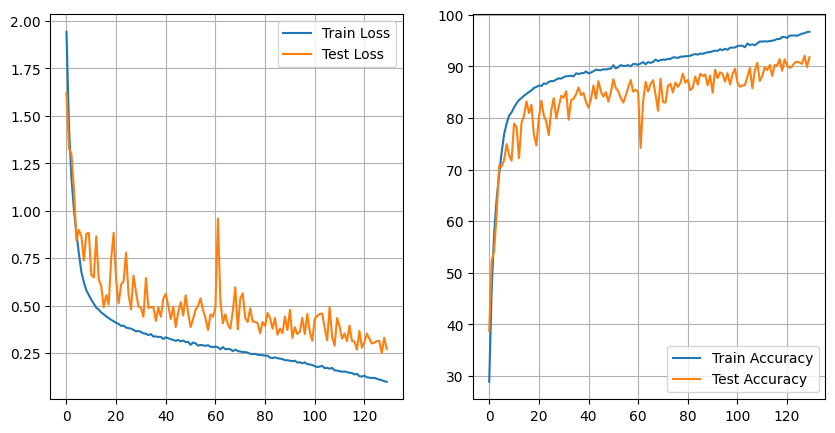

In [20]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
x_axis = range(EPOCHS)
ax0.plot(x_axis, history['loss'], label='Train Loss')
ax0.plot(x_axis, history['test_loss'], label='Test Loss')
ax1.plot(x_axis, history['accuracy'], label='Train Accuracy')
ax1.plot(x_axis, history['test_accuracy'], label='Test Accuracy')
ax0.grid(True)
ax1.grid(True)
ax0.legend()
ax1.legend()
f.savefig("./trainTestCurve.png")

## Visualize the Predictions

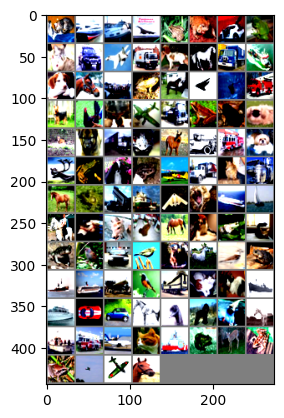

GroundTruth:  cat   ship  ship  plane


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Plot Confusion Matrix

In [22]:
def get_predictions(model, iterator, device):
  ## Set model to evaluate mode 

  model.eval()
  
  ## Labels and probability lists 

  labels = []
  probs = []
  
  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

In [23]:
labels, probs = get_predictions(net, testloader, device)
pred_labels = torch.argmax(probs, 1)

In [24]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10, 10));
  ax = fig.add_subplot(1, 1, 1);
  cm = confusion_matrix(labels, pred_labels);
  cm = ConfusionMatrixDisplay(cm, display_labels = classes);
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20)

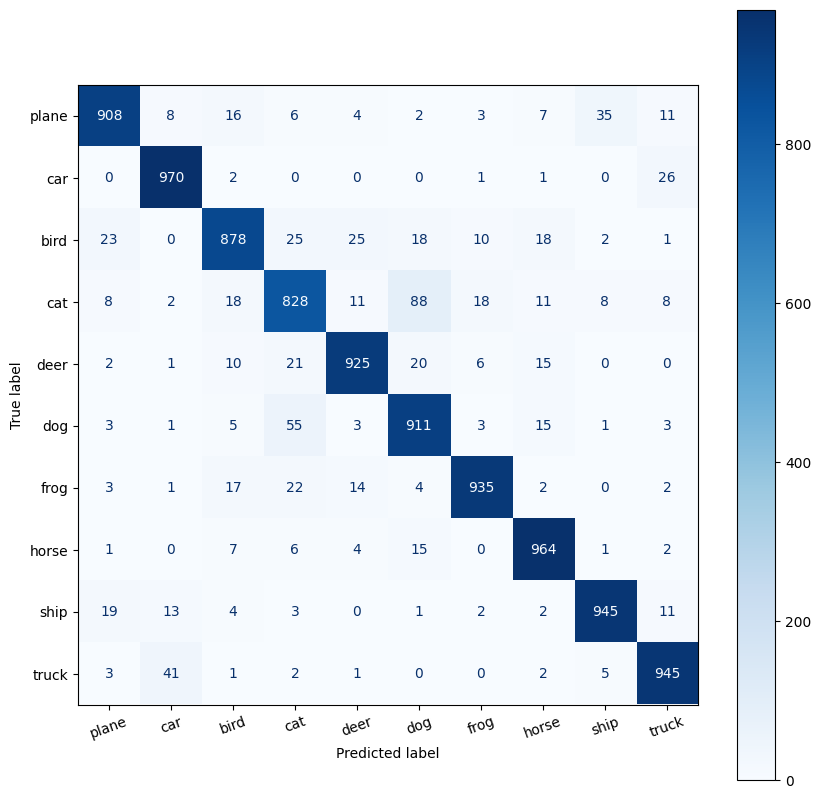

In [25]:
plot_confusion_matrix(labels, pred_labels, classes)